# <p style="text-align: center;">Clustering and Logistic Regression</p>
### <p style="text-align: center;">University of Denver</p>
### <p style="text-align: center;">Alex Liddle</p>

In [42]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Mini Project 1
### Diabetes Risk Clustering

Using clustering and logistic regression, can a dataset containing individuals with risk of diabetes be further divided into groups and then have those groups predicte?

### Load the data

In [9]:
df = pd.read_csv('diabetes2.csv')
# Check for missing values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [10]:
# Check data types
df.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [11]:
# Confirm that the dependent variable is binary
df.Outcome.unique()

array([1, 0])

In [12]:
# See a sample
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data Preprocessing

In [87]:
# Scale independent variables with MinMaxScaler
X = df.drop(['Outcome'], axis=1)
columns = X.columns
X = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=columns)
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000


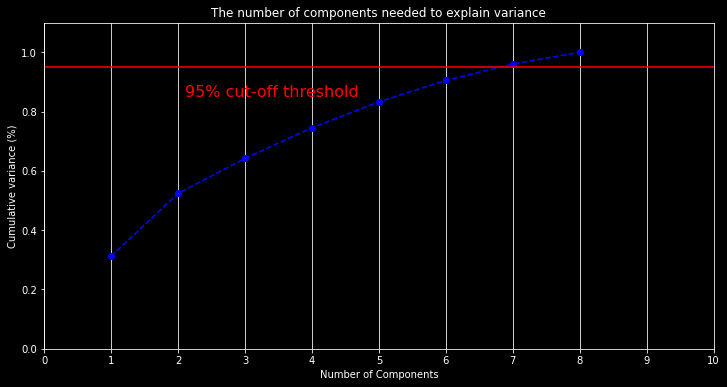

In [88]:
# Conduct PCA
pca = PCA().fit(X)

plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams.update({"ytick.color" : "w",
                     "xtick.color" : "w",
                     "axes.labelcolor" : "w",
                     "axes.edgecolor" : "w"} )
fig, ax = plt.subplots()

y = np.cumsum(pca.explained_variance_ratio_)
xi = np.arange(1, len(y)+1, step=1)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(2.1, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')

plt.style.use('dark_background')
plt.show()

The optimal nnumber of components is 7

In [89]:
pca = PCA(n_components=7)
X = pd.DataFrame(pca.fit_transform(X), columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7'])
X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.304955,0.090382,-0.020112,0.017773,0.073746,0.090092,-0.120929
1,-0.193298,-0.072952,0.127663,-0.031797,0.056881,0.134364,-0.004889
2,0.218108,-0.127575,-0.267315,0.035510,-0.051241,-0.280774,0.014483
3,-0.298826,-0.057153,0.106211,-0.020300,-0.083639,0.047974,0.059983
4,-0.169495,0.382749,-0.313636,0.286165,0.629871,-0.064556,-0.126115


### Clustering

Use agglomerative clustering and visualize the dendogram to determine optimal number of clusters

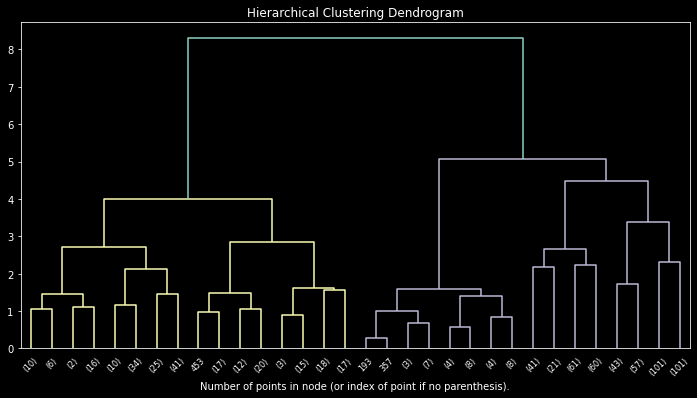

In [90]:
def plot_dendrogram(model, **kwargs):
    '''
    plot_dendogram function can be found at 
    https://scikit-learn.org/stable/auto_examples/cluster/
            plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py
    '''
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(X)
    
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Looking around 4 on the vertical axis, it looks like 3 is an optimal number of clusters

In [110]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

In [111]:
def find_optimal_clusters(data, max_k):
    k_list = range(2, max_k+1)
    
    sse = []
    for k in k_list:
        sse.append(KMeans(n_clusters=k, random_state=42).fit(data).inertia_)
       
    plt.style.use("dark_background")
    f, ax = plt.subplots(1, 1)
    ax.plot(k_list, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(k_list)
    ax.set_xticklabels(k_list)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

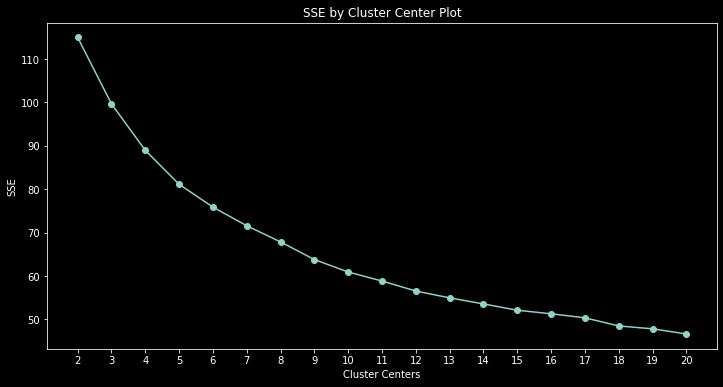

In [112]:
find_optimal_clusters(X, 20)

The plot is relatively smooth, though it does look like there is a slight elbow at 3, which matches the optimal number of clusters from the dendogram.

In [113]:
# Add the cluster label to use as new labels for Logistic Regression
df_clustered = X.copy()
df_clustered['cluster'] = y_kmeans
df_clustered.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster
0,0.304955,0.090382,-0.020112,0.017773,0.073746,0.090092,-0.120929,1
1,-0.193298,-0.072952,0.127663,-0.031797,0.056881,0.134364,-0.004889,2
2,0.218108,-0.127575,-0.267315,0.035510,-0.051241,-0.280774,0.014483,1
3,-0.298826,-0.057153,0.106211,-0.020300,-0.083639,0.047974,0.059983,2
4,-0.169495,0.382749,-0.313636,0.286165,0.629871,-0.064556,-0.126115,0


Split the dataset into a train and test set

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df_clustered.drop(['cluster'],axis=1),
                                                    df_clustered.cluster, test_size=0.3, random_state=42)

### Model Selection

In [115]:
param_grid=[{"C":[0.2, 0.4, 0.6, 0.8, 1.0]}]
grid=GridSearchCV(estimator=LogisticRegression(random_state=42),param_grid=param_grid,cv=5)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid=[{'C': [0.2, 0.4, 0.6, 0.8, 1.0]}])

In [116]:
grid.best_params_

{'C': 1.0}

In [117]:
# training accuracy
grid.score(X_train,y_train)

0.9646182495344506

In [118]:
# test accuracy
grid.score(X_test,y_test)

0.9826839826839827

### Interpretation

In [136]:
df['cluster'] = y_kmeans
df.groupby('cluster').mean()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
cluster,,,,,,,,,
0,1.893720,136.299517,73.222222,34.628019,171.966184,36.651208,0.584444,28.869565,0.444444
1,7.666667,130.431624,76.418803,17.376068,62.551282,32.519658,0.476603,46.717949,0.525641
2,2.345566,104.318043,61.266055,13.877676,33.798165,28.666361,0.397235,26.363914,0.162080


Judging from the results, it would appear that the clusters formed do not translate perfectly into diabetes risk, since all clusters contain individuals both with and without risk of diabetes. It could be said, however, that, based on the group the individual is clustered with, their risk of diabetes either increases or decreases. This risk appears correlated with several of the independent variables, such as Blood Pressure and age.

# Mini Project 2
###  Diabetes Risk Clustering